# Project - Phase 2

## Part 1: Preprocessing
This part was already doen in phase 1. So we just load the preprocessed dataframe here.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report , ConfusionMatrixDisplay, confusion_matrix

In [2]:
FILE_PATH = 'df_encoded.csv'
PALETTE = [ "#023E8A", "#0077B6", "#00B4D8", "#90E0EF", "#FFB3C6", "#FF8FAB", "#FB6F92" ]
COLOR_MAP = sns.color_palette(palette=PALETTE, as_cmap=True)
LABELS = ['Not Reached', 'Reached']

In [3]:
df = pd.read_csv(FILE_PATH)

In [4]:
df.head(5)

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,cost_of_the_product_per_gram,cost_with_discount
0,-0.047711,0.25,-0.690722,-0.372735,0,0,1.889983,-1.468240,1,0,0,0,1,0,1,0,0,0.470442,0.614731
1,-0.047711,1.00,0.120746,-1.029424,0,1,2.815636,-0.333893,1,0,0,0,0,1,1,0,0,-0.361629,-0.219230
2,-1.799887,0.25,-0.565881,0.283954,0,1,2.136824,-0.159002,1,1,0,0,0,0,1,0,0,3.558949,0.643307
3,-0.923799,0.50,-0.711529,0.283954,1,1,-0.208162,-1.502484,1,0,1,0,0,0,1,0,0,0.473568,-0.859642
4,-1.799887,0.25,-0.545074,-0.372735,1,0,2.013404,-0.703244,1,0,0,1,0,0,1,0,0,0.775085,0.552380


In this step, first we handled missing values and there was no missing value. Then we checked if there is any duplicate rows and there was none. After that we handled the object data. Object data with two categories such as gender where divided to 0 and 1 (0 for male, 1 for female). For product_importance since there are three levels of importance we assigned 0 to low 1 to medium and 2 to high. For other object data we used one-hot encoding. Then we checked if there are any redundant features by calculating the correlation between each two features. if the correlation was above 0.9 we dropped one of the feature columns. For features scaling we used MinMaxScaler for customer_rating column because this column is from 0 to 5 and since then minimum and maximum are specified we can use MinMaxScaler. for other numerical features we use standardScalar so that the mean of each column is 0 and this standard deviation is 1. We also dropped the ID column.

## Part 2: Feature Engineering and Selection
In the previous phase we added 2 additional columns called `cost_of_the_product_per_gram` and `cost_with_discount`. Here is the importance of each feature:

In [5]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X = df.drop(columns=['Reached.on.Time_Y.N'])
y = df['Reached.on.Time_Y.N']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importances.head(5)
X_selected = X[top_10_features['feature']]

In [6]:
feature_importances.head(10)

,feature,importance
7,Weight_in_gms,0.197352
6,Discount_offered,0.176261
16,cost_of_the_product_per_gram,0.136548
17,cost_with_discount,0.119243
2,Cost_of_the_Product,0.112873
3,Prior_purchases,0.043766
1,Customer_rating,0.043323
0,Customer_care_calls,0.039747
4,Product_importance,0.024027
5,Gender,0.018408


## Part 3: Dimensionality Reduction

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numerical_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
                      'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'cost_of_the_product_per_gram',	'cost_with_discount']

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df[numerical_features])

explained_variance = pca.explained_variance_ratio_
pca_df = pd.DataFrame(data=pca_transformed, columns=['PC1', 'PC2'])

print(pca_df.head(10))
print(f"Total Explained Variance by the two principal components: {explained_variance.sum() * 100:.2f}%")
pca_df.to_csv('pca_df.csv', index=False)

        PC1       PC2
0 -2.601475 -0.422066
1 -3.433563  0.221762
2  0.487126  0.263074
3 -2.598377  0.925277
4 -2.296782  0.268660
5 -2.332281  1.369854
6 -4.144288 -1.215788
7 -4.006753  0.271482
8 -1.916759  1.831890
9 -2.429569  0.472596
Total Explained Variance by the two principal components: 100.00%


100% of the initial data variance is transferred to the new space

In [8]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95_variance = (cumulative_variance >= 0.95).argmax() + 1
n_components_95_variance

1

To retain 95% of the original variance, the minimum number of dimensions
required in the new space is 1.

## Part 4: Evaluation Metric
This is a classification problem with the goal to predict whether a product will reach on time based on the given features. Hence, the metrics we decided to use are:
  - F1-Score: Given it balances precision and recall, it's effective for scenarios where both false positives and false negatives are important.
  - ROC-AUC: To assess the overall performance of the classifier, particularly with imbalanced classes.
  - Confusion Matrix: To understand the true positives, true negatives, false positives, and false negatives, providing insight into where the model is making errors.
  - Precision and Recall: To individually evaluate the classifier's performance on positive predictions and actual positives

## Part 5: Model Training

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_train = y_train.values
y_test = y_test.values

### Method One: Neural Network

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=1)


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - accuracy: 0.5697 - loss: 1.4964 - val_accuracy: 0.6722 - val_loss: 0.5229
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6564 - loss: 0.5328 - val_accuracy: 0.6778 - val_loss: 0.5140
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6629 - loss: 0.5246 - val_accuracy: 0.6869 - val_loss: 0.5096
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.6634 - loss: 0.5248 - val_accuracy: 0.6790 - val_loss: 0.5100
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6588 - loss: 0.5193 - val_accuracy: 0.6847 - val_loss: 0.5064
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6625 - loss: 0.5194 - val_accuracy: 0.6903 - val_loss: 0.5061
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6771 - loss: 0.5132 - val_accuracy: 0.6892 - val_loss: 0.5036
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6634 - loss: 0.5180 - val_

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(y_test, y_pred, target_names=LABELS)
print(report)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('ROC AUC : %.2f' % auc(fpr, tpr))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.6823 - loss: 0.5036
Test Loss: 0.5026869773864746
Test Accuracy: 0.6850000023841858
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
              precision    recall  f1-score   support

 Not Reached       0.57      0.97      0.71       895
     Reached       0.96      0.49      0.65      1305

    accuracy                           0.69      2200
   macro avg       0.76      0.73      0.68      2200
weighted avg       0.80      0.69      0.68      2200

ROC AUC : 0.73


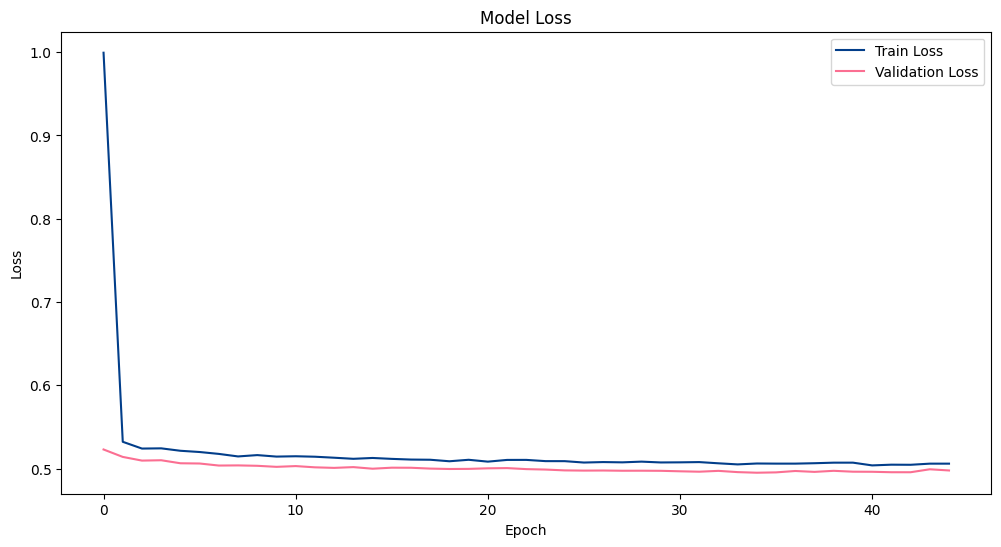

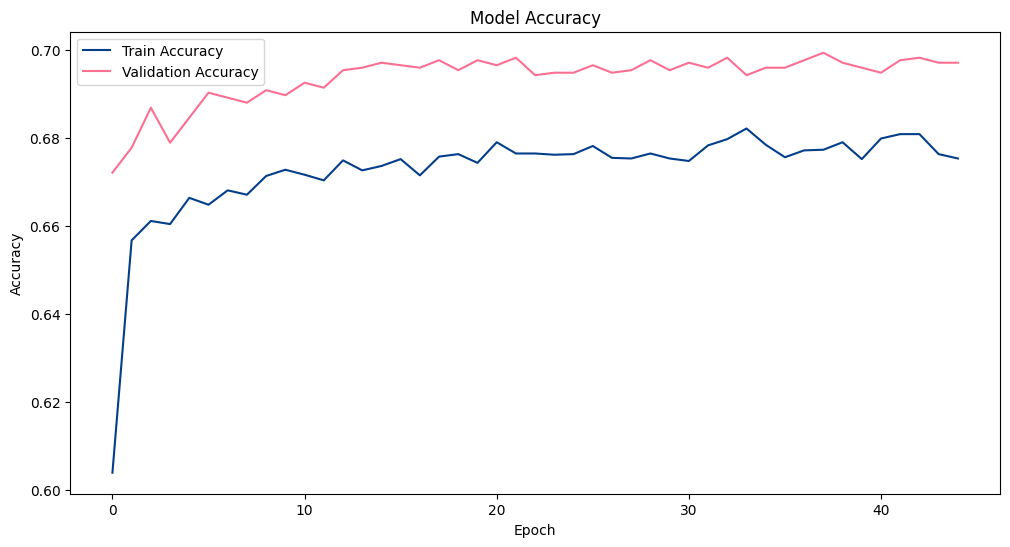

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], PALETTE[0], label='Train Loss')
plt.plot(history.history['val_loss'], PALETTE[6], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], PALETTE[0], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], PALETTE[6], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


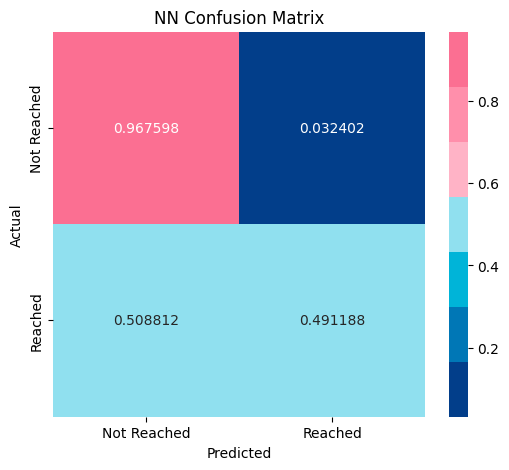

In [14]:
m = confusion_matrix(y_test, y_pred)
normalized_cm = m.astype('float') / m.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(6, 5))
sns.heatmap(normalized_cm, annot=True, fmt='f', cmap=PALETTE, cbar=True, xticklabels=LABELS, yticklabels=LABELS)
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Based on the problem's context (e.g., predicting timely delivery), one might prioritize recall to ensure that as many on-time deliveries are correctly identified as possible, or precision to avoid false alarms

Network Architecture:
  - First Dense Layer: 64 neurons, ReLU activation, takes input with shape (X_train.shape[1],).
  - First Dropout Layer: Drops 30% of the units.
  - Second Dense Layer: 32 neurons, ReLU activation.
  - Second Dropout Layer: Drops 30% of the units.
  - Third Dense Layer: 16 neurons, ReLU activation.
  - Output Layer: 1 neuron, Sigmoid activation for binary classification.

Loss Function: Binary Cross-Entropy, suitable for binary classification.

Optimization Algorithm: Adam optimizer, known for its efficiency and performance.

### Method Two: Decision Tree

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier , export_text

In [54]:
RANDOM_STATE = 50

In [55]:
grid = {
    "criterion": ["gini"],
    "max_depth": range(2, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
}
decisionTreeGrid = GridSearchCV(
    estimator=DecisionTreeClassifier( random_state = 2),
    param_grid=grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)
decisionTreeGrid.fit(X_train, y_train)
decision_tree_predicted = decisionTreeGrid.best_estimator_.predict(X_test)

In [56]:
text_representation = export_text(decisionTreeGrid.best_estimator_, feature_names=list(X_train.columns))
print(text_representation)

|--- Discount_offered <= -0.18
|   |--- Weight_in_gms <= 0.30
|   |   |--- Cost_of_the_Product <= 0.11
|   |   |   |--- Weight_in_gms <= 0.23
|   |   |   |   |--- class: 1
|   |   |   |--- Weight_in_gms >  0.23
|   |   |   |   |--- class: 1
|   |   |--- Cost_of_the_Product >  0.11
|   |   |   |--- Weight_in_gms <= -1.00
|   |   |   |   |--- class: 0
|   |   |   |--- Weight_in_gms >  -1.00
|   |   |   |   |--- class: 1
|   |--- Weight_in_gms >  0.30
|   |   |--- cost_with_discount <= 2.60
|   |   |   |--- cost_of_the_product_per_gram <= -2.11
|   |   |   |   |--- class: 0
|   |   |   |--- cost_of_the_product_per_gram >  -2.11
|   |   |   |   |--- class: 0
|   |   |--- cost_with_discount >  2.60
|   |   |   |--- class: 1
|--- Discount_offered >  -0.18
|   |--- class: 1



In [57]:
print(f"Decision Tree Accuracy: {decisionTreeGrid.score(X_test, y_test) * 100:2.2f}%")
report = classification_report(y_test, decision_tree_predicted, target_names=LABELS)
print(report)

fpr, tpr, thresholds = roc_curve(y_test, decision_tree_predicted, pos_label=1)
print('ROC AUC : %.2f' % auc(fpr, tpr))

Decision Tree Accuracy: 69.05%
              precision    recall  f1-score   support

 Not Reached       0.57      0.94      0.71       895
     Reached       0.93      0.52      0.67      1305

    accuracy                           0.69      2200
   macro avg       0.75      0.73      0.69      2200
weighted avg       0.78      0.69      0.68      2200

ROC AUC : 0.73


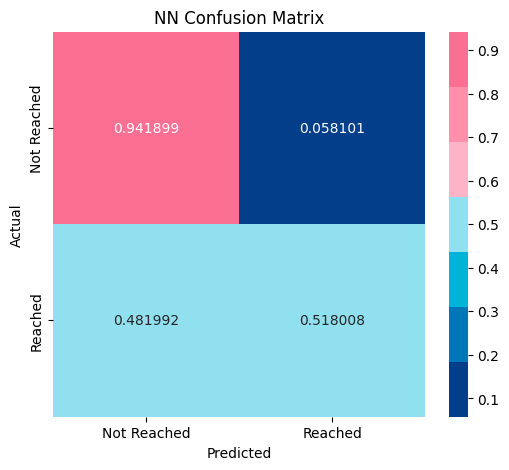

In [58]:
decision_tree_confusion_matrix = confusion_matrix(y_test, decision_tree_predicted)

# Normalize the confusion matrix
normalized_cm = decision_tree_confusion_matrix.astype('float') / decision_tree_confusion_matrix.sum(axis=1)[:, np.newaxis]

# Create the heatmap
fig = plt.figure(figsize=(6, 5))
sns.heatmap(normalized_cm, annot=True, fmt='f', cmap=PALETTE, cbar=True, xticklabels=LABELS, yticklabels=LABELS)

# Add titles and labels
plt.title('NN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Show the plot
plt.show()

### Method Three: SVM

## Part 6: Feature Analysis

## Part 7: Overall Report and Discussions